# Harmonizing OsmFISH dataset (Linarsson Lab) and Zeisel's Cortex dataset

# Table of Contents
0. [Creating and training the model](#Creating and training the model)
1. [Imputation](#Imputation)
2. [Getting a common meaningful representation](#Getting a common meaningful representation)
3. [Classifying smFISH cells in different cell types](#Classifying smFISH cells in different cell types)
3. [Imputation of non-observed genes for OsmFISH](#Imputation of non-observed genes for OsmFISH)

## Imputation
We train our model and the baseline without observing some smFISH genes (sox10 and Gad2 in this exemple). We then try to reconstruct the unobserved values for each cell, an compare them with the real ones. 
For the baseline we use a k-NN approach, and for our model we directly output the expected counts.
We also compute, for each of those unobserved genes, the absolute and relative errors.
## Getting a common meaningful representation
Here, we'd like two things. First, the two datasets should mix pretty well (if the common representation captures biologically relevant information). This is measured by the Entropy of Batch Mixing (maximum possible value: 0.68, minimum possible value: 0.00, value for our method: 0.50, value for baseline: 0.10).
We also plot the latent represnetation of the cells according to their cell types, hoping that cells from different datasets but same cell types lie close to each other in our latent space.
To check that our representation is meaningful, we plot the expression of marker genes for sub-cell types for scRNA-seq data. That allows us to see that our representation conserves data structure at the sub cell type level.
## Classifying smFISH cells in different cell types
Here, we use a k-NN classifier for the baseline, and a SVC classifier on the expected frequencies of the model for our method.
## Imputation of non-observed genes for OsmFISH
We start by imputing marker genes for different cell types and show that the expected frequencies are correlated with the expression of other marker genes for the same cell types, to ensure consistency of our model.
We then impute a gene supposed to be spatially differentially expressed, and show that the expected counts imputed by our model for this gene are also spatially differentially expressed (last figure of the notebook).


In [1]:
cd ~/scVI

/home/ubuntu/scVI


In [2]:
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
from scvi.dataset import CortexDataset, SmfishDataset
from scvi.inference import TrainerFish
from scvi.models import VAEF
from scvi.inference.posterior import plot_imputation, compute_accuracy_nn, proximity_imputation, entropy_batch_mixing
from scvi.inference.annotation import compute_accuracy_svc
from scvi.inference import adversarial_wrapper

# 1. Creating and training the model

In [3]:
genes_to_discard = ['gad2', 'sox10']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


 We run with 50 additional genes for the scRNA-seq dataset

In [4]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=50)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [5]:
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=1, n_latent=8,
           n_layers=1, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.3, n_labels=7, n_batch=2, model_library=False)
trainer = TrainerFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.9, verbose=False, frequency=5, weight_decay=0.30, n_epochs_even=1, n_epochs_kl=1000,
                                cl_ratio = 30, n_epochs_cl=150)
trainer = adversarial_wrapper(trainer, scale=50, warm_up =10,mode="smFISH")
trainer.train(n_epochs=50, lr=0.001)
data_loader_fish = trainer.train_fish
data_loader_seq = trainer.train_seq


training: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


In [6]:
import torch
def get_dataset_information(vae, data_loader, mode="scRNA"):
    """ Gives access to information about the data points in the data_loader,
        as well as on outputs of the model for those data points (latent embedding,
        expected_frequencies...)
    """
    to_get = {"latent": [], "batch_indices": [],
              "labels": [], "values": [], "expected_frequencies": [], "x_coord": [], "y_coord": []}
    vae.eval()
    for tensors in data_loader:
        if mode == "scRNA":
            sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
            to_get["latent"] += [vae.sample_from_posterior_z(sample_batch, y=label)]
            to_get["expected_frequencies"] += [vae.get_sample_scale(sample_batch, batch_index=batch_index)]
        if mode == "smFISH":
            sample_batch, local_l_mean, local_l_var, batch_index, label, x_coord, y_coord = tensors
            to_get["x_coord"] += [x_coord]
            to_get["y_coord"] += [y_coord]
            to_get["latent"] += [vae.sample_from_posterior_z(sample_batch, y=label, mode=mode)]
            to_get["expected_frequencies"] += [vae.get_sample_scale(sample_batch, mode=mode, batch_index=batch_index)]
        to_get["batch_indices"] += [batch_index]
        to_get["labels"] += [label]
        to_get["values"] += [sample_batch]
    for key in to_get.keys():
        if len(to_get[key]) > 0:
            to_get[key] = np.array(torch.cat(to_get[key]))
    return to_get

In [7]:
data_loader_fish = trainer.train_fish
data_loader_seq = trainer.train_seq
# Getting data of interest
dic = get_dataset_information(vae, data_loader_seq, mode="scRNA")
latent_seq, labels_seq, expected_frequencies_seq, values_seq = dic["latent"], dic["labels"], dic["expected_frequencies"], dic["values"]
dic = get_dataset_information(vae, data_loader_fish, mode="smFISH")
latent_fish, labels_fish, expected_frequencies_fish, values_fish = dic["latent"], dic["labels"], dic["expected_frequencies"], dic["values"]
x_coord = dic["x_coord"]
y_coord = dic["y_coord"]

In [8]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, vae.indexes_to_keep], gene_dataset_seq.X[:, vae.indexes_to_keep]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels

# 2. Imputation

In [9]:
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

idx_gad = get_index(gene_dataset_seq.gene_names, "gad2")
idx_sox = get_index(gene_dataset_seq.gene_names, "sox10")

Found idx 0 for gene gad2!
Found idx 17 for gene sox10!


## Imputing missing gene GAD2: our method vs baseline

In [10]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original-imputed)
    relative_error = 0.5 * absolute_error / (1 + np.abs(original) + np.abs(imputed))
    return {"mean_absolute_error": np.mean(absolute_error), "median_absolute_error": np.median(absolute_error), 
            "mean_relative_error": np.mean(relative_error), "median_relative_error": np.median(relative_error)}   

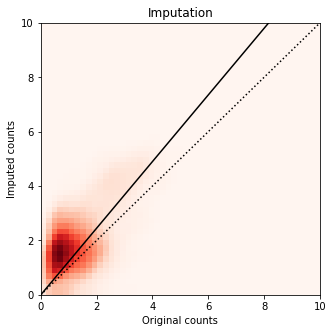

{'mean_absolute_error': 9.5559874, 'median_absolute_error': 3.0839996, 'mean_relative_error': 0.22176935, 'median_relative_error': 0.22147079}


<Figure size 432x288 with 0 Axes>

In [11]:
imputed = expected_frequencies_fish[:, idx_gad] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
plot_imputation(np.log(1+values_fish[:, idx_gad]), np.log(1+imputed))
print(imputation_metrics(values_fish[:, idx_gad], imputed))

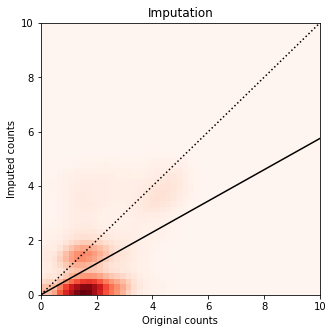

{'mean_absolute_error': 11.406786489850052, 'median_absolute_error': 4.0, 'mean_relative_error': 0.28234528292814626, 'median_relative_error': 0.33333333333333331}


<Figure size 432x288 with 0 Axes>

In [12]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_gad], PCA_latent_fish, k=5)
mean = np.mean(PCA_values_fish[:, idx_gad])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_gad])) if PCA_values_fish[idx, 0]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_gad]))
print(imputation_metrics(PCA_values_fish[:, idx_gad], predicted_PCA))

## Imputing missing gene SOX10: our method vs baseline

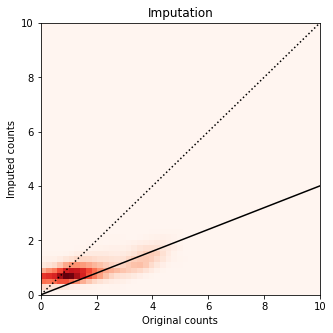

{'mean_absolute_error': 8.6527672, 'median_absolute_error': 1.3954079, 'mean_relative_error': 0.22070897, 'median_relative_error': 0.21287829}


<Figure size 432x288 with 0 Axes>

In [13]:
imputed = expected_frequencies_fish[:, idx_sox] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
mean = np.mean(values_fish[:, idx_sox])
plot_imputation(np.log(1+imputed), np.log(1+values_fish[:, idx_sox]))
print(imputation_metrics(values_fish[:, idx_sox], imputed))

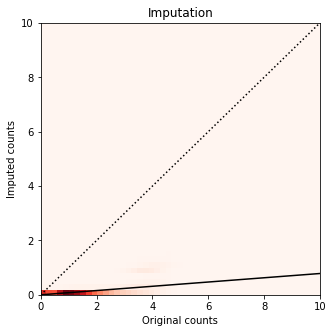

{'mean_absolute_error': 9.5345638829362525, 'median_absolute_error': 2.0, 'mean_relative_error': 0.30823845332601435, 'median_relative_error': 0.33333333333333331}


<Figure size 432x288 with 0 Axes>

In [14]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_sox], PCA_latent_fish, k=5)
mean = np.mean(PCA_values_fish[:, idx_sox])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_sox])) if PCA_values_fish[idx, idx_sox]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_sox]))
print(imputation_metrics(PCA_values_fish[:, idx_sox], predicted_PCA))

# 3. Getting a common meaningful representation

In [15]:
from sklearn.manifold import TSNE
def get_common_t_sne(latent_seq, latent_fish, n_samples=1000):
    idx_t_sne_a = np.random.permutation(len(latent_seq))[:n_samples]
    idx_t_sne_b = np.random.permutation(len(latent_fish))[:n_samples]
    full_latent = np.concatenate((latent_seq[idx_t_sne_a, :], latent_fish[idx_t_sne_b, :]))
    if full_latent.shape[1] != 2:
        latent = TSNE().fit_transform(full_latent)
    if latent.shape[0] != len(idx_t_sne_a) + len(idx_t_sne_b):
        print("Be careful! There might be a mistake in the downsampling of the data points")
    return latent[:len(idx_t_sne_a), :], latent[len(idx_t_sne_a):, :], idx_t_sne_a, idx_t_sne_b
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


## Our method: Embedding of the two datasets in the shared latent space

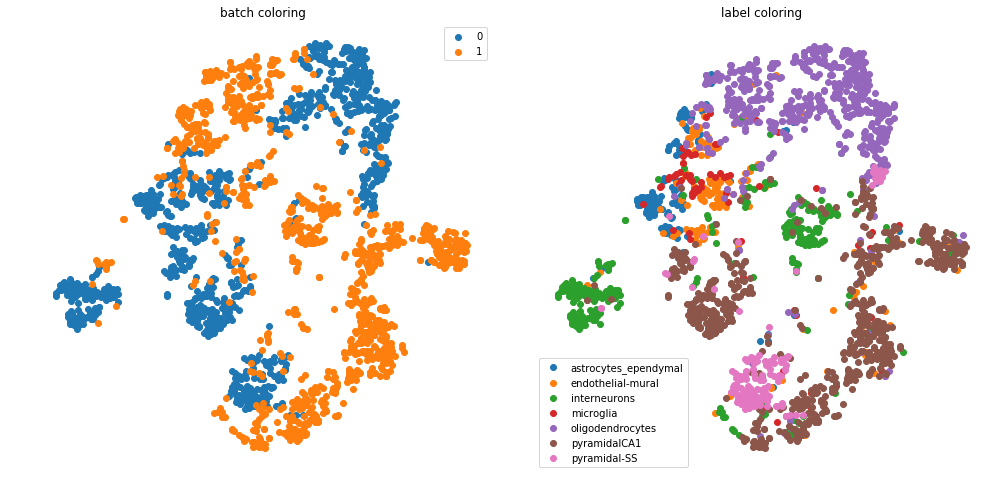

In [16]:
latent = np.concatenate((t_sne_seq, t_sne_fish), axis=0)
labels = np.concatenate((labels_seq[idx_t_sne_seq], labels_fish[idx_t_sne_fish]), axis=0)
batch_indices = np.concatenate((np.zeros_like(labels_seq[idx_t_sne_seq]), np.ones_like(labels_fish[idx_t_sne_fish])), axis=0)
trainer.train_seq.show_t_sne(None, color_by='batches and labels', latent=latent, labels =labels.ravel(), batch_indices = batch_indices.ravel(), n_batch=2)

** Note: In the OsmFISH dataset labels, there is no difference between pyramidal CA1 and pyramidal SS. That explains why the pink datapoints from Cortex's Zeisel dataset are mixed with brown datapoints from the OsmFISH dataset.**

## Benchmark: Embedding of the two datasets in the shared latent space

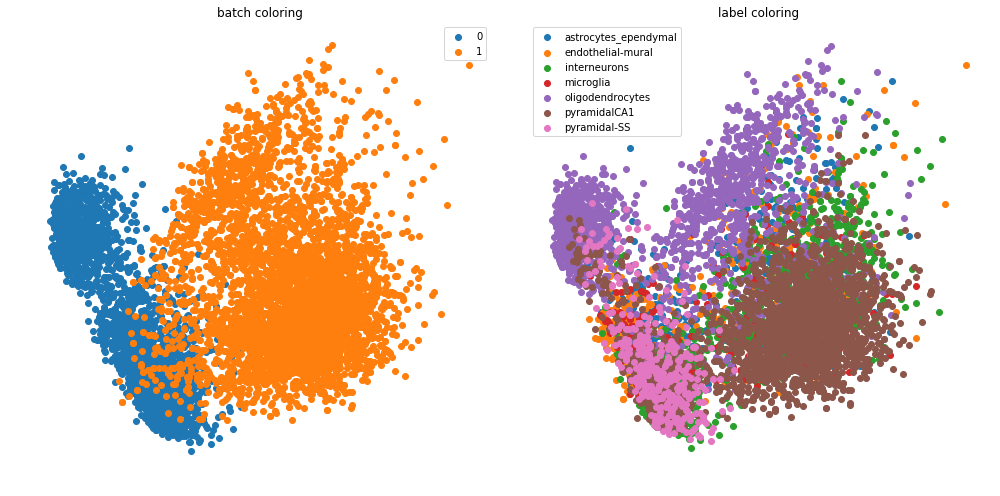

In [17]:
latent = np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2]), axis=0)
labels = np.concatenate((PCA_labels_seq, PCA_labels_fish), axis=0)
batch_indices = np.concatenate((np.zeros_like(PCA_labels_seq), np.ones_like(PCA_labels_fish)), axis=0)
trainer.train_seq.show_t_sne(None, color_by='batches and labels', latent=latent, labels =labels.ravel(), batch_indices = batch_indices.ravel(), n_batch=2)

# show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel())


## Batch entropy: How well do the datasets mix in the latent space?

In [18]:
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

0.397821768475


In [19]:
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros(len(PCA_latent_seq)),
                                                  np.ones(len(PCA_latent_fish))))))

0.0985830270399


## Is the data structure conserved in the latent space?

We plot the values of expected frequencies of marker genes for sub-cell types for scRNA-seq data. If cells with high values for those genes are grouped together, it means that the structure at the sub-cell-type scale is conserved within the latent space

In [20]:
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")

Found idx 80 for gene gja1!
Found idx 66 for gene mog!
Found idx 37 for gene sst!


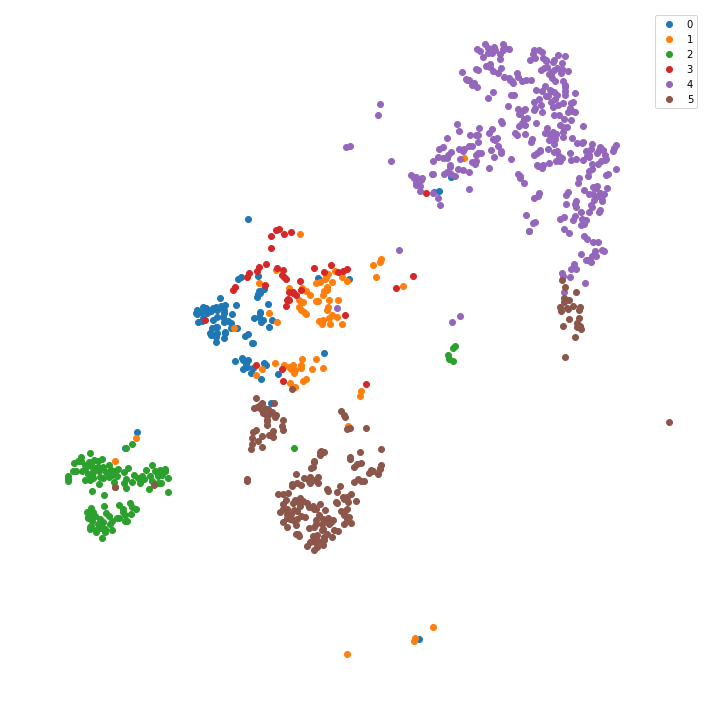

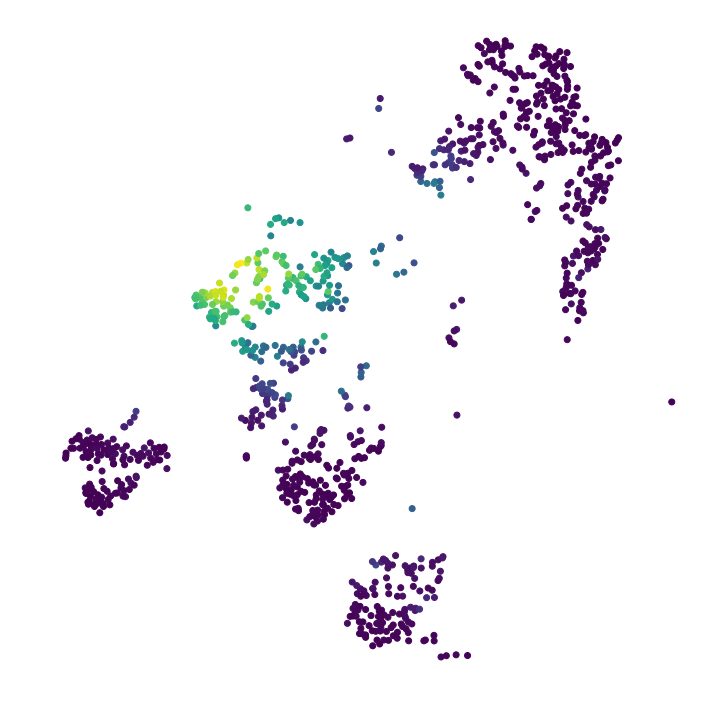

In [21]:
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_seq, labels =labels_seq[idx_t_sne_seq].ravel())
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_astro])

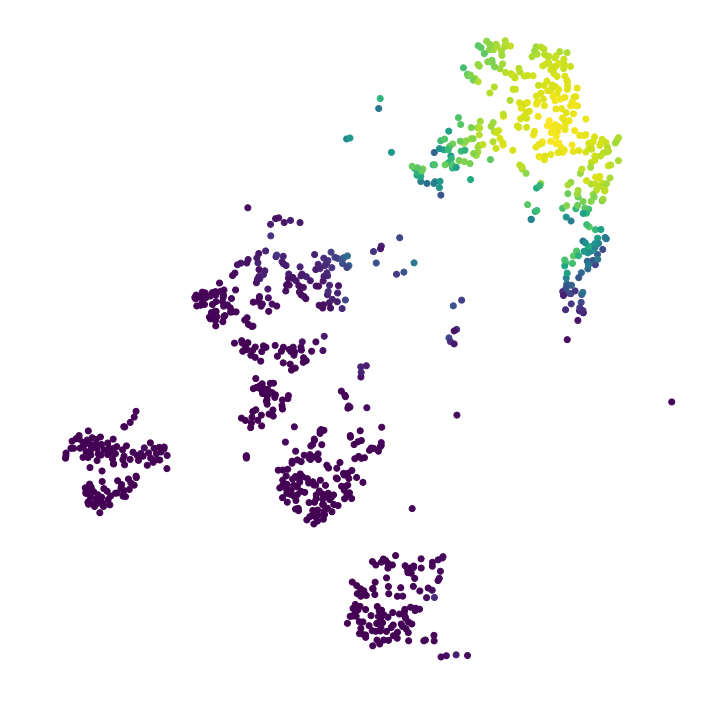

In [22]:
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_oligo])

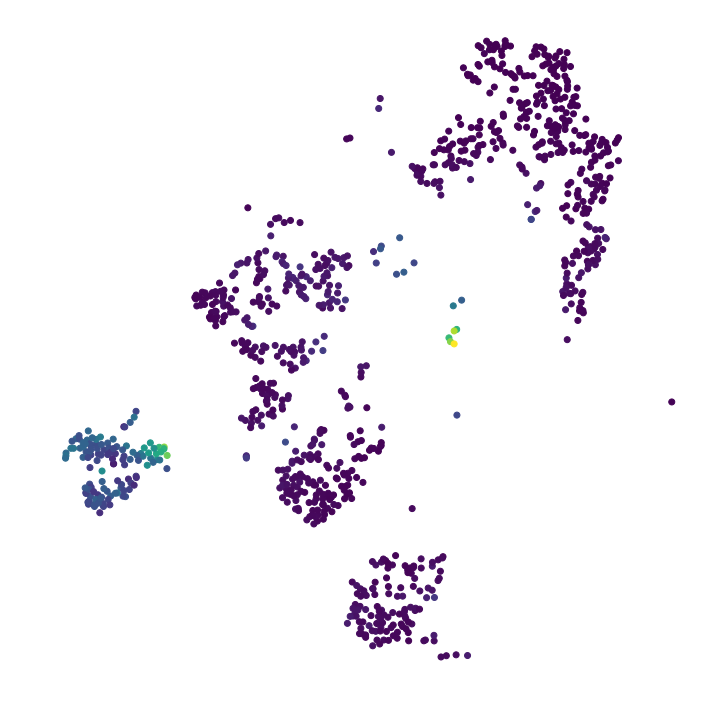

In [23]:
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_interneurons])

# 4. Classifying cells in different cell types

In [ ]:
# No distinction between pyramidal CA1 and pyramidal SS in the OsmFISH dataset
for label in range(len(labels_seq)):
    if labels_seq[label] == 6:
        labels_seq[label] = 5
for label in range(len(PCA_labels_seq)):
    if PCA_labels_seq[label] == 6:
        PCA_labels_seq[label] = 5

(_, accuracy_svc), inferred_labels_svc = compute_accuracy_svc(expected_frequencies_seq, labels_seq.ravel(), expected_frequencies_fish, labels_fish.ravel())
(_, PCA_accuracy), PCA_inferred_labels = compute_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel())


Accuracy and PCA_accuracy: KNN classifier based on our latent space and the baseline's latent space.                    
Accuracy_svc: obtained using a SVC classifier trained on the predicted expected frequencies for the counts 

In [ ]:
print(PCA_accuracy)
print(accuracy_svc)

## Comparing inferred vs real labels: our method

In [ ]:
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =inferred_labels_svc[idx_t_sne_fish].ravel())

In [ ]:
# compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels)
trainer.train_fish.show_t_sne(None, color_by='labels', latent=PCA_latent_fish[:, :2], labels =PCA_labels_fish.ravel())
trainer.train_fish.show_t_sne(None, color_by='labels', latent=PCA_latent_fish[:, :2], labels = PCA_inferred_labels.ravel())

# 5. Going further: Imputing unobserved genes for the smFISH experiment

First, we impute marker genes for different cell types, to ensure the consistency of our model

## Astrocytes marker gene imputation

In [ ]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_astro])

## Oligodendrocytes marker gene imputation
This marker gene defines a finer cell type within the astrocytes population. Here, we see a clear gradient of expression for this gene.   

Imputation of refined cell types marker gene is a feature that could help us get a more precise spatial map of cell types 

In [ ]:
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_oligo])

In [ ]:
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_interneurons])

## Spatial imputation

Now that we can impute values for smFISH cells, we can estimate a spatial map for the gene expression of genes sequenced with scRNA-seq

In [ ]:
trainer.train_fish.show_spatial_expression(x_coord, y_coord,
                        labels_fish, color_by='label',
                        title="")

In [ ]:
trainer.train_fish.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_astro],
                        title="")

In [ ]:
trainer.train_fish.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_oligo],
                        title="")

In [ ]:
trainer.train_fish.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_interneurons],
                        title="")

## Finding spatially differentialy expressed genes

In [ ]:
trainer.train_fish.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, 45],
                        title="")

### Comparing with ground truth and KNN predictor

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

s=10
gene_name = "sox10"#"gad2", "meg3", "sox10"
#gene_name = gene_name_oligo = "mog"
idx_gene_seq = get_index(gene_dataset_seq.gene_names, gene_name) # the index of one gene
idx_gene_fish = get_index(gene_dataset_fish.gene_names, gene_name)

x_coord_ = x_coord.ravel()
y_coord_ = y_coord.ravel()

x_coord_pca = gene_dataset_fish.x_coord.ravel()
y_coord_pca = gene_dataset_fish.y_coord.ravel()


predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_gene_seq], PCA_latent_fish, k=5)

axes[0].scatter(x_coord_pca, y_coord_pca, c=gene_dataset_fish.X[:,idx_gene_seq].ravel(), s=s)
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].scatter(x_coord_, y_coord_, c=expected_frequencies_fish[:, idx_gene_seq].ravel(), s=s)
axes[1].set_title("Our prediction")
axes[1].axis("off")

axes[2].scatter(x_coord_pca, y_coord_pca, c=predicted_PCA.ravel(), s=s)
axes[2].set_title("PCA + KNN Predictor")
axes[2].axis("off")
plt.suptitle("Spatial comparison of Gene Expression level for gene: %s "%gene_name)
plt.savefig("spatial-comparison.png")